## Use states as voters instead of congressmen

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import networkx as nx
import numpy as np
import re

import glob, os
import itertools
from tqdm import tqdm

import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

import sys
sys.path.append('../local/bin/')
from sygno.nodes_position import _get_xcoord
from sygno.states_signed_networkx import draw_signed_networkx


In [4]:
dataset_folder = '../dataset/'
mmb = pd.read_csv('../dataset/HSall_members.csv')
pc = pd.read_csv('../dataset/HSall_parties.csv')

In [97]:
def create_members_df():
    temp_congress = mmb.groupby('icpsr', as_index=False)[['congress']].agg(lambda x: list(x))
    temp_party = mmb.groupby('icpsr', as_index=False)[['party_code']].agg(lambda x: list(set(x)))
    temp_congress = temp_congress.merge(temp_party)
    temp_congress['bioname'] = temp_congress['icpsr'].map(mmb[['icpsr', 'bioname']].set_index('icpsr').to_dict()['bioname'])
    temp_congress['state_abbrev'] = temp_congress['icpsr'].map(mmb[['icpsr', 'state_abbrev']].set_index('icpsr').to_dict()['state_abbrev'])
    temp_congress['district_code'] = temp_congress['icpsr'].map(mmb[['icpsr', 'district_code']].set_index('icpsr').to_dict()['district_code'])
    party_codes_dic = pc[['party_name', 'party_code']].set_index('party_code').to_dict()['party_name']
    temp_congress['party_name'] = temp_congress['party_code'].apply(lambda x: [party_codes_dic[y] for y in x])
    return temp_congress

members = create_members_df()

members2state_dic = members.set_index('icpsr')['state_abbrev'].to_dict()
members2district_dic = members.set_index('icpsr')['district_code'].to_dict()
members_party_dict = members.set_index('icpsr')['party_name'].to_dict()

In [4]:
def create_state_edgelist_from_congress(congress, frac_state):
	
	edgelist = pd.DataFrame()
	pol_dic = {}

	def state_party_rnd_func(state, congress, frac):
		congress_state = congress[congress['state_abbrev'] == state]
		congress_state_rnd = congress_state.sample(frac=frac)
		return congress_state_rnd['member_party_name'].value_counts().index[0]
	
	# for every state, define its party using the state_party_rnd_func function ONCE AND FOR ALL (in the current congress)
	for state in set(congress['state_abbrev']):
		if state and (len(state) == 2 or len(state) == 3):
			pol_dic[state] = state_party_rnd_func(state, congress, frac_state)
		else:
			continue

	for voteid in set(congress['id']):                 		 # iterate over all votes id (ids are unique for each vote)

		temp = congress[congress['id'] == voteid]            # select the rows where the vote id is equal to the current vote id            

		yy = temp[temp['vote']=='Yea']['state_abbrev']       # select the icpsr of the members that voted "Yea"
		nn = temp[temp['vote']=='Nay']['state_abbrev']       # select the icpsr of the members that voted "Nay']                        

		y = itertools.combinations(yy, 2)                    # all possible combinations of 2 members that voted "Yea"
		n = itertools.combinations(nn, 2)                
		o = itertools.product(yy, nn)                        # cartesian product of the 2 series

		y = pd.DataFrame(y, columns = ['source', 'target'])  # create a dataframe from the combinations of "Yea" voters
		y['weight'] = 1                                      # add a column with the weight of the edge
		y['count'] = 1                                         

		n = pd.DataFrame(n, columns = ['source', 'target'])     
		n['weight'] = 1                                         
		n['count'] = 1                                          

		o = pd.DataFrame(o, columns = ['source', 'target'])     
		o['weight'] = -1                                     # same but the link is negative                    
		o['count'] = 1                                          

		edgelist = pd.concat([edgelist, y, n, o])
		edgelist = edgelist.groupby(['source', 'target', 'weight']).sum().reset_index()     # group by source, target and weight and sum the count                  

	edgelist = pd.concat([edgelist, pd.DataFrame({
		'source': edgelist['target'],                        # new columns based on old columns: 
		'target': edgelist['source'],                        #   'newcolumn': dataframe['oldcolumn']
		'weight': edgelist['weight'],
		'count': edgelist['count']})])

	edgelist = edgelist.loc[edgelist['source'] < edgelist['target']]                    						# remove duplicates
	edgelist = edgelist.groupby(['source', 'target', 'weight']).sum().reset_index()     						# group by source, target and weight and sum the count
	edgelist['party'] = edgelist.apply(lambda row: 'in' if pol_dic[row['source']] == pol_dic[row['target']] else 'out', axis=1)  	# create a column with the party of the edge

	map_votes = edgelist.groupby(['source', 'target'])['count'].sum().to_dict()                                 # create a dictionary with the number of votes togheter for each pair of nodes                               

	edgelist['votes_togheter'] = edgelist[['source', 'target']].apply(lambda x: map_votes[(x['source'], x['target'])], axis=1)
	edgelist['perc'] = edgelist['count']/edgelist['votes_togheter']

	return edgelist, pol_dic

In [5]:
def compute_threshold_intersx(df, weight):	#df is the edgelist, weight is the weight of the edge

	def _midpoint(p1, p2):
		return {'x': (p1['x']+p2['x'])/2, 'y': (p1['y']+p2['y'])/2}

	def line_intersection(in_party, out_party, intersect_points):
		index_in = np.argmax(in_party[1])
		index_out = np.argmax(out_party[1])

        # points of the mean of the distributions 
		point_in={'x': in_party[0][index_in], 'y': in_party[1][index_in]}
		point_out={'x': out_party[0][index_out], 'y': out_party[1][index_out]}

        # medianpoint (mean of the means) of the two distributions
		midpoint = _midpoint(point_in, point_out)
        
        #find index of intersection closer to midpoint
		index_closer = np.argmin([np.sqrt( (p[0] - midpoint['x'])**2 + (p[1] - midpoint['y'])**2 ) for p in intersect_points])

        # return x value of closer intersection
		return intersect_points[index_closer][0]

	x0 = df.loc[(df['party']=='in')&(df['weight'] == weight)]['perc']
	x1 = df.loc[(df['party']=='out')&(df['weight'] == weight)]['perc']
    
	bw = len(x0)**(-1./(2+4))
	kde0 = gaussian_kde(x0, bw_method=bw)
	bw = len(x1)**(-1./(2+4))
	kde1 = gaussian_kde(x1, bw_method=bw)

	xmin = min(x0.min(), x1.min())
	xmax = max(x0.max(), x1.max())
	dx = 0.2 * (xmax - xmin) # add a 20% margin, as the kde is wider than the data
	xmin -= dx
	xmax += dx

	x = np.linspace(xmin, xmax, 500)
	kde0_x = kde0(x)
	kde1_x = kde1(x)
	inters_x = np.minimum(kde0_x, kde1_x)

	idx = np.argwhere(np.diff(np.sign(kde0_x - kde1_x))).flatten()
    
	threshold = line_intersection([x, kde0_x], [x, kde0_x], [[x,y] for x,y in zip (x[idx], kde1_x[idx])])
	area_inters_x = np.trapz(inters_x, x)

	return threshold, area_inters_x

In [6]:
def compute_eigen(df):
    def compute_d_max(G):
        max_d = 0
        for edge in G.edges(data=True):
            temp = G.degree[edge[0]] + G.degree[edge[1]]
            if temp > max_d:
                max_d = temp
        return max_d / 2

    G = nx.from_pandas_edgelist(df, 'source', 'target', ['weight'])
    df, least_eigenvalue = _get_xcoord(G, compact=False)
    max_d = compute_d_max(G)
    eig = 1-(least_eigenvalue/(max_d-1))
    return eig

_________________________________________________________________________________________________

### Let's try to track the dynamics without introducing fluctuations

In [57]:
# if it does not exist create the folder "statebased_edgelists"
if not os.path.exists('../dataset/statebased_edgelists/'):
    os.makedirs('../dataset/statebased_edgelists/')

# and the folder for the thresholds
if not os.path.exists('../dataset/statebased_thresholds/'):
    os.makedirs('../dataset/statebased_thresholds/')

In [47]:
house_congress_path = '../dataset/download_votes_merged/'
senate_congress_path = '../dataset/download_votes_merged_senate/'

Generate edgelists

In [48]:
frac = 0.5

In [151]:
# clean the folder
import shutil
#shutil.rmtree('../dataset/statebased_edgelists_house/*.csv')
#shutil.rmtree('../dataset/statebased_thresholds_house/*.csv')

In [ ]:
for csv in tqdm(glob.glob(house_congress_path+'*.csv')):
    
    congress = pd.read_csv(csv)
    congress['state_abbrev'] = congress['icpsr'].map(members2state_dic)
    congress['code_district'] = congress['icpsr'].map(members2state_dic)
    congress['member_party_name'] = congress['icpsr'].map(members_party_dict)
    n_congress = re.findall(r'\d+', csv)[0]
    
    if not os.path.exists('../dataset/statebased_edgelists_house/edgelist_'+n_congress+'.csv'):
        edgelist, pol_dic = create_state_edgelist_from_congress(congress, frac)
        # print the dictionary as a csv of two columns
        pd.DataFrame.from_dict(pol_dic, orient='index').to_csv('../dataset/statebased_edgelists_house/pol_dic_'+n_congress+'.csv')
        
        edgelist.to_csv('../dataset/statebased_edgelists_house/edgelist_'+n_congress+'.csv', index=False)
    else:
        edgelist = pd.read_csv('../dataset/statebased_edgelists_house/edgelist_'+n_congress+'.csv')
    
    if not os.path.exists('../dataset/statebased_thresholds_house/threshold_'+n_congress+'.csv'):
        len_df = len(congress['bill_number'].unique())
        threshold_pos, area_pos = compute_threshold_intersx(edgelist, 1)
        threshold_neg, area_neg = compute_threshold_intersx(edgelist, -1)
        df_output = pd.DataFrame({
            'pos_threshold': [threshold_pos],
            'pos_area': [area_pos],
            'neg_threshold': [threshold_neg],
            'neg_area': [area_neg],
            'n_votes': [len_df]
        })
        df_output.to_csv('../dataset/statebased_thresholds_house/threshold_'+n_congress+'.csv', index=False)

In [149]:
# for each congress filter the edgelist with the threshold and save the normalized eigenvalue in a dictionary where the key is the congress number
eig_dic_house = {}
n_votes_dic_house = {}

for csv in tqdm(glob.glob('../dataset/statebased_edgelists_house/*.csv')):
    n_congress = re.findall(r'\d+', csv)[0]
    edgelist = pd.read_csv(csv)
    
    threshold_pos = pd.read_csv('../dataset/statebased_thresholds_house/threshold_'+n_congress+'.csv')['pos_threshold'][0]
    threshold_neg = pd.read_csv('../dataset/statebased_thresholds_house/threshold_'+n_congress+'.csv')['neg_threshold'][0]

    df_pos = edgelist.loc[(edgelist['weight']==1)&(edgelist['perc']>threshold_pos)].copy()
    df_neg = edgelist.loc[(edgelist['weight']==-1)&(edgelist['perc']>threshold_neg)].copy()
    edgelist_filtered = pd.concat([df_pos, df_neg])
    eig_dic_house[n_congress] = compute_eigen(edgelist_filtered)
    n_votes = pd.read_csv('../dataset/statebased_thresholds_house/threshold_'+n_congress+'.csv')['n_votes']
    n_votes_dic_house[n_congress] = n_votes

100%|██████████| 41/41 [00:00<00:00, 45.14it/s]


Text(0.5, 1.0, 'Statebased Normalized Least Eigenvalues (House)')

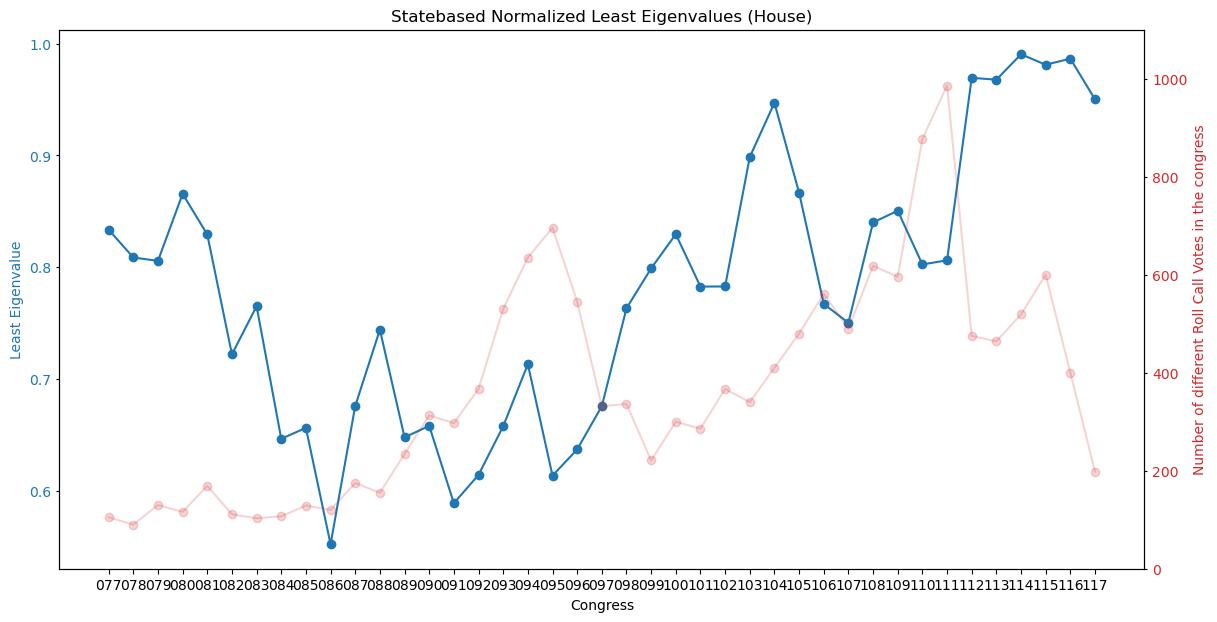

In [144]:
# plot the eigenvalues sorting the dictionary by key
congress_list_house = sorted(eig_dic_house.keys())
eigenvalue_list_house = [eig_dic_house[x] for x in congress_list_house]

fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:blue'
ax1.set_xlabel('Congress')
ax1.set_ylabel('Least Eigenvalue', color=color)
ax1.plot(congress_list_house, eigenvalue_list_house, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color, size=2)

# Create a second y-axis
ax2 = ax1.twinx()

n_votes_list_house = [n_votes_dic_house[x] for x in congress_list_house]
color = 'tab:red'
ax2.set_ylabel('Number of different Roll Call Votes in the congress', color=color)
ax2.plot(congress_list_house, n_votes_list_house, 'o-', color=color, alpha=0.2)
ax2.tick_params(axis='y', labelcolor=color, size=2)
ax2.set_ylim([0, 1100])

# set title
plt.title('Statebased Normalized Least Eigenvalues (House)')

Now do the same but for the senate

In [ ]:
# clean the folders
import shutil
#shutil.rmtree('../dataset/statebased_edgelists_senate/*.csv')
#shutil.rmtree('../dataset/statebased_thresholds_senate/*.csv')

In [157]:
for csv in tqdm(glob.glob(senate_congress_path+'*.csv')):
    
    congress = pd.read_csv(csv)
    congress['state_abbrev'] = congress['icpsr'].map(members2state_dic)
    congress['code_district'] = congress['icpsr'].map(members2state_dic)
    congress['member_party_name'] = congress['icpsr'].map(members_party_dict)
    n_congress = re.findall(r'\d+', csv)[0]
    
    if not os.path.exists('../dataset/statebased_edgelists_senate/edgelist_'+n_congress+'.csv'):
        edgelist = create_state_edgelist_from_congress(congress, frac)
        edgelist.to_csv('../dataset/statebased_edgelists_senate/edgelist_'+n_congress+'.csv', index=False)
    else:
        edgelist = pd.read_csv('../dataset/statebased_edgelists_senate/edgelist_'+n_congress+'.csv')
    
    if not os.path.exists('../dataset/statebased_thresholds_senate/threshold_'+n_congress+'.csv'):
        len_df = len(congress['bill_number'].unique())
        threshold_pos, area_pos = compute_threshold_intersx(edgelist, 1)
        threshold_neg, area_neg = compute_threshold_intersx(edgelist, -1)
        df_output = pd.DataFrame({
            'pos_threshold': [threshold_pos],
            'pos_area': [area_pos],
            'neg_threshold': [threshold_neg],
            'neg_area': [area_neg],
            'n_votes': [len_df]
        })
        df_output.to_csv('../dataset/statebased_thresholds_senate/threshold_'+n_congress+'.csv', index=False)

100%|██████████| 41/41 [26:47<00:00, 39.21s/it]


In [146]:
# for each congress filter the edgelist with the threshold and save the normalized eigenvalue in a dictionary where the key is the congress number
eig_dic_senate = {}
n_votes_dic_senate = {}

for csv in tqdm(glob.glob('../dataset/statebased_edgelists_senate/*.csv')):
    n_congress = re.findall(r'\d+', csv)[0]
    edgelist = pd.read_csv(csv)
    
    threshold_pos = pd.read_csv('../dataset/statebased_thresholds_senate/threshold_'+n_congress+'.csv')['pos_threshold'][0]
    threshold_neg = pd.read_csv('../dataset/statebased_thresholds_senate/threshold_'+n_congress+'.csv')['neg_threshold'][0]

    df_pos = edgelist.loc[(edgelist['weight']==1)&(edgelist['perc']>threshold_pos)].copy()
    df_neg = edgelist.loc[(edgelist['weight']==-1)&(edgelist['perc']>threshold_neg)].copy()
    edgelist_filtered = pd.concat([df_pos, df_neg])
    eig_dic_senate[n_congress] = compute_eigen(edgelist_filtered)
    n_votes = pd.read_csv('../dataset/statebased_thresholds_senate/threshold_'+n_congress+'.csv')['n_votes']
    n_votes_dic_senate[n_congress] = n_votes

100%|██████████| 41/41 [00:00<00:00, 49.92it/s]


Text(0.5, 1.0, 'Statebased Normalized Least Eigenvalues (Senate)')

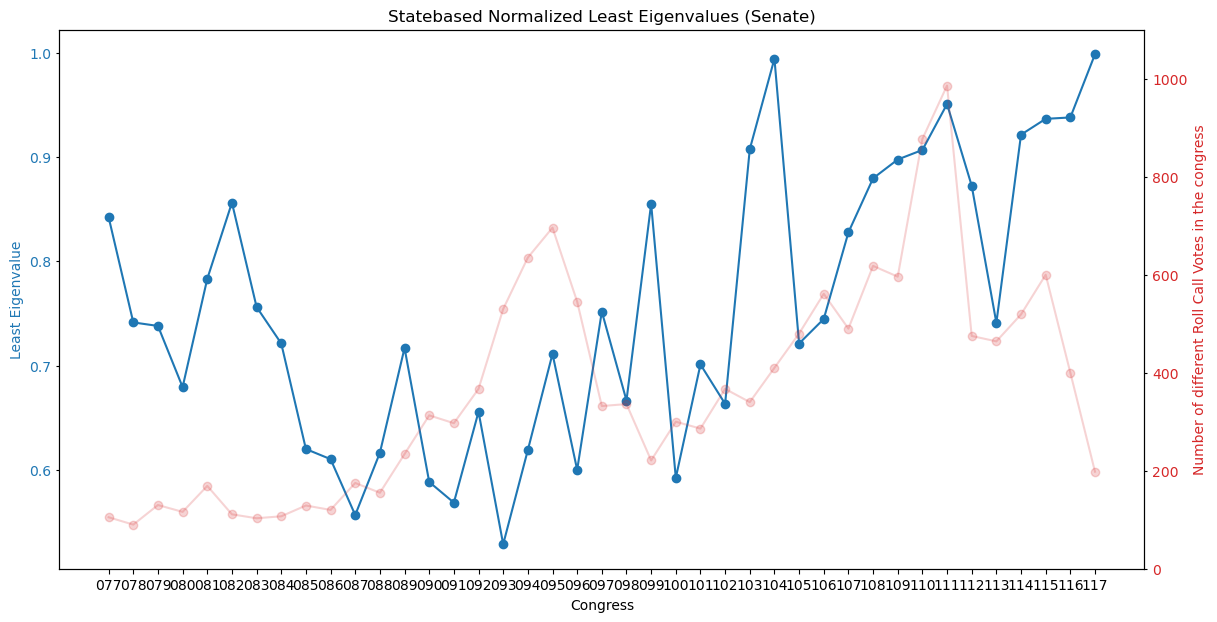

In [158]:
# plot the eigenvalues sorting the dictionary by key
congress_list_senate= sorted(eig_dic_senate.keys())
eigenvalue_list_senate = [eig_dic_senate[x] for x in congress_list_senate]

fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:blue'
ax1.set_xlabel('Congress')
ax1.set_ylabel('Least Eigenvalue', color=color)
ax1.plot(congress_list_senate, eigenvalue_list_senate, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color, size=2)

# Create a second y-axis
ax2 = ax1.twinx()

n_votes_list_senate = [n_votes_dic_house[x] for x in congress_list_senate]
color = 'tab:red'
ax2.set_ylabel('Number of different Roll Call Votes in the congress', color=color)
ax2.plot(congress_list_house, n_votes_list_senate, 'o-', color=color, alpha=0.2)
ax2.tick_params(axis='y', labelcolor=color, size=2)
ax2.set_ylim([0, 1100])

# set title
plt.title('Statebased Normalized Least Eigenvalues (Senate)')

____________________________________________________________________________________________________

# Introduce fluctuations using a "Monte-Carlo like" procedure
#### The party of a state is now established random-sampling 50% of the members from that state during the congress

...

In [7]:
# define the parameters of the randomization
n_simulations_house = 100             # number of simulations to perform for each congress
n_simulations_senate = 100

frac_state_members_house = 0.5        # number of sampled members for each state to determine the "party" of the state (House)
frac_state_members_senate = 1.0       # number of sampled members for each state to determine the "party" of the state (Senate)

# define a matrix to store the results of the simulations, number of rows = number of simulations, number of columns = number of congresses
n_congresses = len(glob.glob('../dataset/download_votes_merged/*.csv'))

results_house, results_senate = np.zeros((n_simulations_house, n_congresses)) , np.zeros((n_simulations_senate, n_congresses))
n_votes_dic_house, n_votes_dic_senate = {} , {}


In [8]:
dataset_folder = '../dataset/'
statebased_folder = dataset_folder+'statebased_analysis/'

In [9]:
def create_from_congress(chamber):

    if chamber=='house':
        csv_path = dataset_folder+'download_votes_merged/*.csv'
        n_simulations = n_simulations_house
        frac_state_members = frac_state_members_house

    elif chamber=='senate':
        csv_path = dataset_folder+'download_votes_merged_senate/*.csv'
        n_simulations = n_simulations_senate
        frac_state_members = frac_state_members_senate

    else:
        print('Error: chamber must be "house" or "senate"')
        return

    for csv in tqdm(glob.glob(csv_path)):

        curr_congr  = pd.read_csv(csv)
        n_congress = re.findall(r'\d+', csv)[0]
    
        curr_congr['state_abbrev'] = curr_congr['icpsr'].map(members2state_dic)
        curr_congr['code_district'] = curr_congr['icpsr'].map(members2state_dic)
        curr_congr['member_party_name'] = curr_congr['icpsr'].map(members_party_dict)

        len_df = len(curr_congr['bill_number'].unique())

        for i in tqdm(range(n_simulations)):
        
            # check if the edgelist and the threshold for the current congress and simulation already exist
            if not os.path.exists(statebased_folder+'mc_statebased_edgelists_'+chamber+'/congress_'+n_congress+'/edgelist_'+n_congress+'_'+str(i)+'.csv') \
            or not os.path.exists(statebased_folder+'mc_statebased_thresholds_'+chamber+'/congress_'+n_congress+'/threshold_'+n_congress+'_'+str(i)+'.csv') \
            or not os.path.exists(statebased_folder+'mc_statebased_poldics_'+chamber+'/congress_'+n_congress+'/poldic_'+n_congress+'_'+str(i)+'.csv'):
                
                curr_edgelist, pol_dic = create_state_edgelist_from_congress(curr_congr, frac_state_members)

                # print the dictionary as a csv of two columns
                if not os.path.exists(statebased_folder+'mc_statebased_poldics_'+chamber+'/congress_'+n_congress+'/'):
                    os.makedirs(statebased_folder+'mc_statebased_poldics_'+chamber+'/congress_'+n_congress+'/')

                if not os.path.exists(statebased_folder+'mc_statebased_edgelists_'+chamber+'/congress_'+n_congress+'/'):
                    os.makedirs(statebased_folder+'mc_statebased_edgelists_'+chamber+'/congress_'+n_congress+'/')

                if not os.path.exists(statebased_folder+'mc_statebased_thresholds_'+chamber+'/congress_'+n_congress+'/'):
                    os.makedirs(statebased_folder+'mc_statebased_thresholds_'+chamber+'/congress_'+n_congress+'/')

                pd.DataFrame.from_dict(pol_dic, orient='index').to_csv(statebased_folder+'mc_statebased_poldics_'+chamber+'/congress_'+n_congress+'/poldic_'+n_congress+'_'+str(i)+'.csv', header=False)
                curr_edgelist.to_csv(statebased_folder+'mc_statebased_edgelists_'+chamber+'/congress_'+n_congress+'/edgelist_'+n_congress+'_'+str(i)+'.csv', index=False)

                threshold_pos, area_pos = compute_threshold_intersx(curr_edgelist, 1)
                threshold_neg, area_neg = compute_threshold_intersx(curr_edgelist, -1)

                df_output = pd.DataFrame({
                    'pos_threshold': [threshold_pos],
                    'pos_area': [area_pos],
                    'neg_threshold': [threshold_neg],
                    'neg_area': [area_neg],
                    'n_votes': [len_df]
                })

                curr_edgelist = pd.read_csv(statebased_folder+'mc_statebased_edgelists_'+chamber+'/congress_'+n_congress+'/edgelist_'+n_congress+'_'+str(i)+'.csv')

                df_output.to_csv(statebased_folder+'mc_statebased_thresholds_'+chamber+'/congress_'+n_congress+'/threshold_'+n_congress+'_'+str(i)+'.csv', index=False)
                df_pos = curr_edgelist.loc[(curr_edgelist['weight']==1)&(curr_edgelist['perc']>threshold_pos)].copy()
                df_neg = curr_edgelist.loc[(curr_edgelist['weight']==-1)&(curr_edgelist['perc']>threshold_neg)].copy()
                curr_edgelist_filtered = pd.concat([df_pos, df_neg])

                if chamber=='house':
                    n_votes_dic_house[n_congress] = len_df
                    results_house[i, int(n_congress)-77] = compute_eigen(curr_edgelist_filtered)
            
                elif chamber=='senate':
                    n_votes_dic_senate[n_congress] = len_df
                    results_senate[i, int(n_congress)-77] = compute_eigen(curr_edgelist_filtered)

            else:
                if chamber=='house':
                    n_votes_dic_house[n_congress] = len_df
                    curr_edgelist = pd.read_csv(statebased_folder+'mc_statebased_edgelists_'+chamber+'/congress_'+n_congress+'/edgelist_'+n_congress+'_'+str(i)+'.csv')
                    threshold_neg = pd.read_csv(statebased_folder+'mc_statebased_thresholds_'+chamber+'/congress_'+n_congress+'/threshold_'+n_congress+'_'+str(i)+'.csv')['neg_threshold'][0]
                    threshold_pos = pd.read_csv(statebased_folder+'mc_statebased_thresholds_'+chamber+'/congress_'+n_congress+'/threshold_'+n_congress+'_'+str(i)+'.csv')['pos_threshold'][0]
                    df_pos = pd.read_csv(statebased_folder+'mc_statebased_edgelists_'+chamber+'/congress_'+n_congress+'/edgelist_'+n_congress+'_'+str(i)+'.csv').loc[(curr_edgelist['weight']==1)&(curr_edgelist['perc']>threshold_pos)].copy()
                    df_neg = pd.read_csv(statebased_folder+'mc_statebased_edgelists_'+chamber+'/congress_'+n_congress+'/edgelist_'+n_congress+'_'+str(i)+'.csv').loc[(curr_edgelist['weight']==-1)&(curr_edgelist['perc']>threshold_neg)].copy()
                    curr_edgelist_filtered = pd.concat([df_pos, df_neg])
                    results_house[i, int(n_congress)-77] = compute_eigen(curr_edgelist_filtered)

            
                elif chamber=='senate':
                    n_votes_dic_senate[n_congress] = len_df
                    curr_edgelist = pd.read_csv(statebased_folder+'mc_statebased_edgelists_'+chamber+'/congress_'+n_congress+'/edgelist_'+n_congress+'_'+str(i)+'.csv')
                    threshold_neg = pd.read_csv(statebased_folder+'mc_statebased_thresholds_'+chamber+'/congress_'+n_congress+'/threshold_'+n_congress+'_'+str(i)+'.csv')['neg_threshold'][0]
                    threshold_pos = pd.read_csv(statebased_folder+'mc_statebased_thresholds_'+chamber+'/congress_'+n_congress+'/threshold_'+n_congress+'_'+str(i)+'.csv')['pos_threshold'][0]
                    df_pos = pd.read_csv(statebased_folder+'mc_statebased_edgelists_'+chamber+'/congress_'+n_congress+'/edgelist_'+n_congress+'_'+str(i)+'.csv').loc[(curr_edgelist['weight']==1)&(curr_edgelist['perc']>threshold_pos)].copy()
                    df_neg = pd.read_csv(statebased_folder+'mc_statebased_edgelists_'+chamber+'/congress_'+n_congress+'/edgelist_'+n_congress+'_'+str(i)+'.csv').loc[(curr_edgelist['weight']==-1)&(curr_edgelist['perc']>threshold_neg)].copy()
                    curr_edgelist_filtered = pd.concat([df_pos, df_neg])
                    results_senate[i, int(n_congress)-77] = compute_eigen(curr_edgelist_filtered)


In [10]:
def plot_kde(df, weight, congress):
    def _midpoint(p1, p2):
    	return {'x': (p1['x']+p2['x'])/2, 'y': (p1['y']+p2['y'])/2}

    def line_intersection(in_party, out_party, intersect_points):
        index_in = np.argmax(in_party[1])
        index_out = np.argmax(out_party[1])

        # points of the mean of the distributions 
        point_in={'x': in_party[0][index_in], 'y': in_party[1][index_in]}
        point_out={'x': out_party[0][index_out], 'y': out_party[1][index_out]}

        # medianpoint (mean of the means) of the two distributions
        midpoint = _midpoint(point_in, point_out)
        
        #find index of intersection closer to midpoint
        index_closer = np.argmin([np.sqrt( (p[0] - midpoint['x'])**2 + (p[1] - midpoint['y'])**2 ) for p in intersect_points])

        # return x value of closer intersection
        return intersect_points[index_closer][0]
        
    label = "agree" if weight == 1 else "disagree"

    x0 = df.loc[(df['party']=='in')&(df['weight'] == weight)]['perc']
    x1 = df.loc[(df['party']=='out')&(df['weight'] == weight)]['perc']
    
    bw = len(x0)**(-1./(2+4))
    kde0 = gaussian_kde(x0, bw_method=bw)
    bw = len(x1)**(-1./(2+4))
    kde1 = gaussian_kde(x1, bw_method=bw)

    xmin = min(x0.min(), x1.min())
    xmax = max(x0.max(), x1.max())
    dx = 0.2 * (xmax - xmin) # add a 20% margin, as the kde is wider than the data
    xmin -= dx
    xmax += dx

    x = np.linspace(xmin, xmax, 500)
    kde0_x = kde0(x)
    kde1_x = kde1(x)
    inters_x = np.minimum(kde0_x, kde1_x)

    idx = np.argwhere(np.diff(np.sign(kde0_x - kde1_x))).flatten()
    
    threshold = line_intersection([x, kde0_x], [x, kde0_x], [[x,y] for x,y in zip (x[idx], kde1_x[idx])])
    
    fig1, ax1 = plt.subplots(1, 1, figsize=(15, 10))
    # fig1.set_size_inches(14, 10)

    ax1.plot(x, kde0_x, color='b', label='intra-party')
    ax1.fill_between(x, kde0_x, 0, color='b', alpha=0.2)

    ax1.plot(x, kde1_x, color='orange', label='inter-party')
    ax1.fill_between(x, kde1_x, 0, color='orange', alpha=0.2)

    ax1.plot(x, inters_x, color='tomato')
    ax1.fill_between(x, inters_x, 0, facecolor='none', edgecolor='tomato', label='intersection', alpha=0.5, hatch='xx')
    
    ax1.axvspan(threshold-0.005, threshold+0.005,color='tomato', alpha=0.7, zorder=10)
    ax1.text(threshold-.25, .93, 'threshold: '+str(round(threshold, 2)), fontsize=23,transform=ax1.transAxes)
    
    area_inters_x = np.trapz(inters_x, x)

    handles, labels = plt.gca().get_legend_handles_labels()
    labels[2] += f': {area_inters_x * 100:.1f} %'
    ax1.tick_params(axis='both', which='major', labelsize=20)

    plt.xlabel('Edges percentage', fontsize=25)
    plt.ylabel('Density', fontsize=25)
    title = "Positive edges" if weight == 1 else "Negative edges"
    c_title = "g" if weight == 1 else "r"
    plt.title(title, fontsize=31, pad=10, ha='left', x=-.1, c=c_title)

    legend1 = plt.legend([handles[0],handles[1]], [labels[0],labels[1]], loc='upper center', bbox_to_anchor=(0.4, 1.08), frameon=False, ncol=2, fontsize=23)
    plt.legend([handles[2]], [labels[2]], loc='upper center', bbox_to_anchor=(0.84, 1.08), frameon=False, ncol=1, fontsize=23)
    plt.gca().add_artist(legend1)
    plt.tight_layout()
    plt.grid(axis='y')
    
    ax1.set_xlim([-0.07, 1.1])
    


    plt.show()
    return threshold, area_inters_x

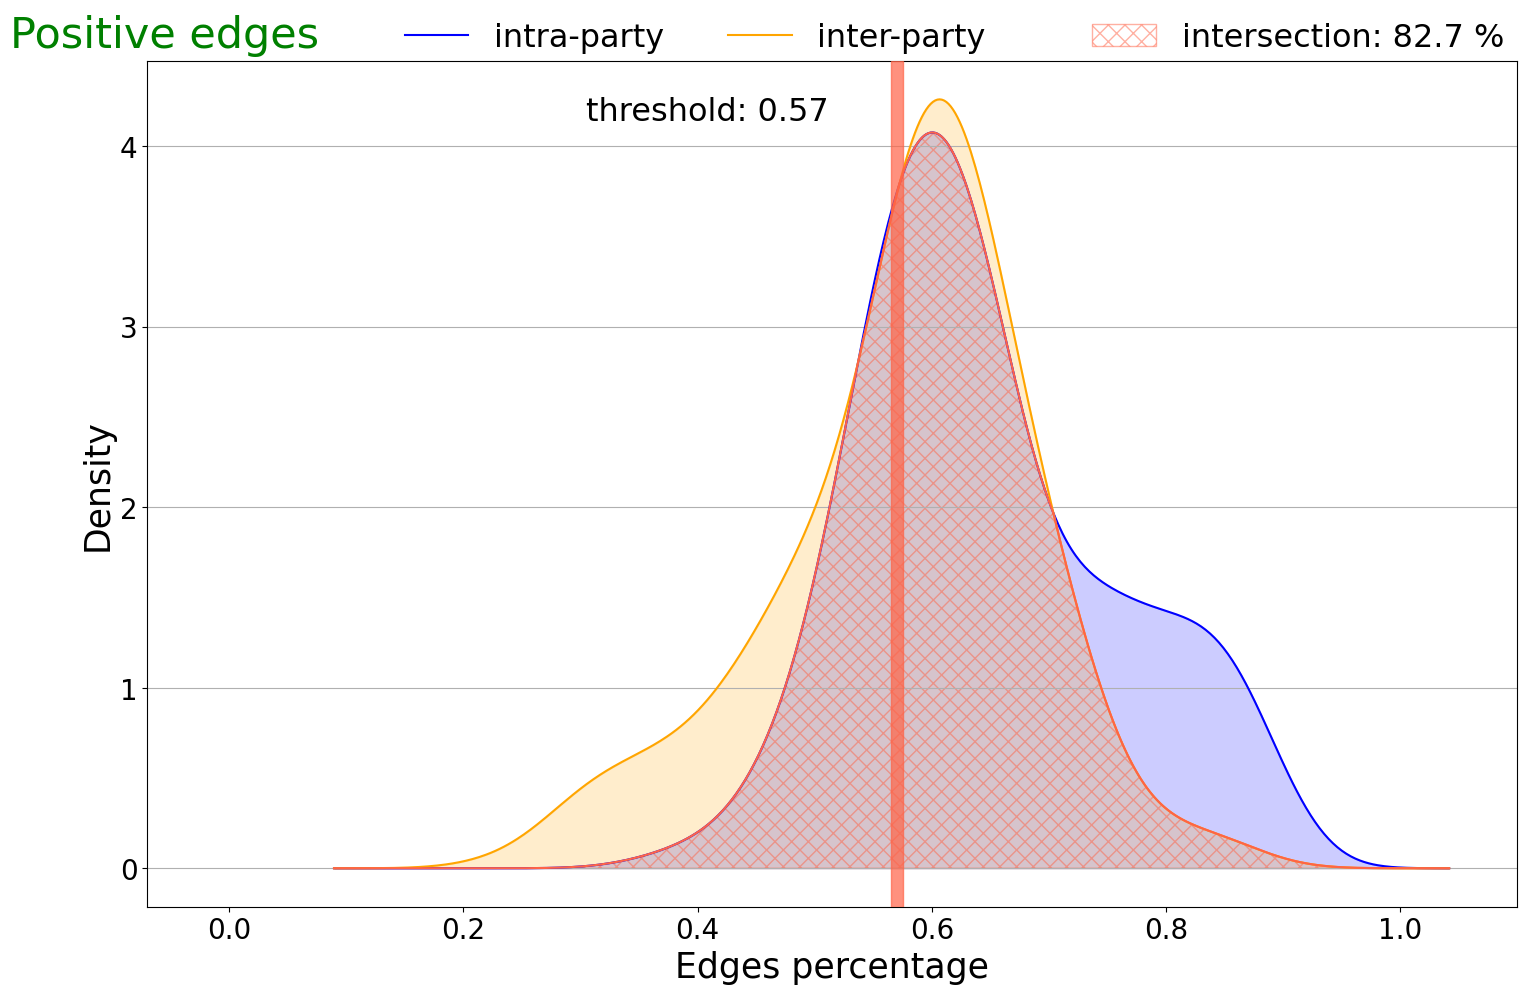

In [11]:
cong = '087'
edgelist = pd.read_csv('../dataset/statebased_analysis/mc_statebased_edgelists_senate/congress_'+cong+'/edgelist_'+cong+'_1.csv')
threshold_pos, area_inters_x_pos = plot_kde(edgelist, 1, str(77))

In [12]:
create_from_congress('house')

  5%|▍         | 2/41 [00:06<02:13,  3.41s/it]/tmp/ipykernel_28246/425106689.py:19: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  curr_congr  = pd.read_csv(csv)
100%|██████████| 41/41 [43:34:00<00:00, 3825.38s/it]  


In [23]:
create_from_congress('senate')

100%|██████████| 41/41 [01:49<00:00,  2.67s/it]


Generate the unfiltered edgelists from each congress

________________________________________________________

## Plot the frustration indices

In [27]:
def plot_statebased_frustrind(chamber, n_votes_dic_chamber, results_chamber):
    fig, ax1 = plt.subplots(figsize=(14, 7))

    color = 'tab:blue'
    ax1.set_xlabel('Congress')
    ax1.set_ylabel('Least Eigenvalue', color=color)
    ax1.plot(range(77, 118), np.mean(results_chamber, axis=0), '-', color=color, alpha=0.8)
    ax1.errorbar(range(77, 118), np.mean(results_chamber, axis=0), yerr=np.std(results_chamber, axis=0), fmt='o', color=color, alpha=0.7)
    ax1.tick_params(axis='y', labelcolor=color, size=2)

    # Create a second y-axis
    ax2 = ax1.twinx()

    n_votes_list = [n_votes_dic_chamber[str(x).zfill(3)] for x in range(77, 118)]
    color = 'tab:red'
    ax2.set_ylabel('Number of different Roll Call Votes in the congress', color=color)
    ax2.plot(range(77, 118), n_votes_list, 'o-', color=color, alpha=0.2)
    ax2.tick_params(axis='y', labelcolor=color, size=2)
    ax2.set_ylim([0, 1100])

    # set title
    plt.title('Statebased Normalized Least Eigenvalues ('+chamber.capitalize()+')')
    plt.savefig('../plots/statebased_eigen_'+chamber+'.png', dpi=300)

#### House

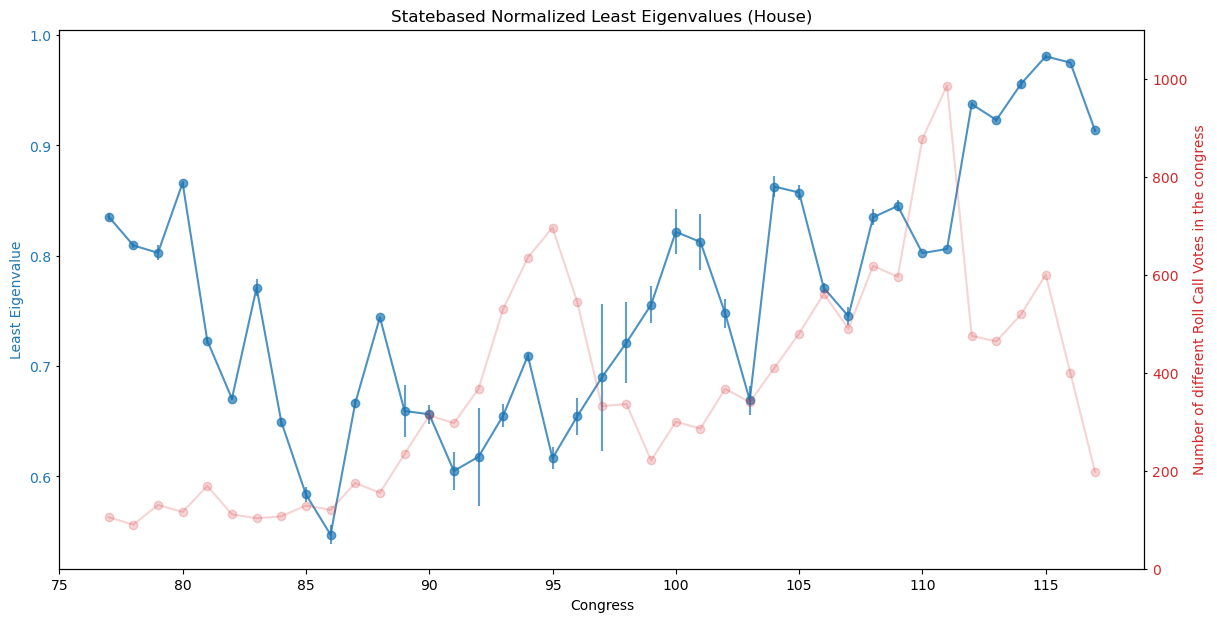

In [31]:
plot_statebased_frustrind('house', n_votes_dic_house, results_house)

### Senate

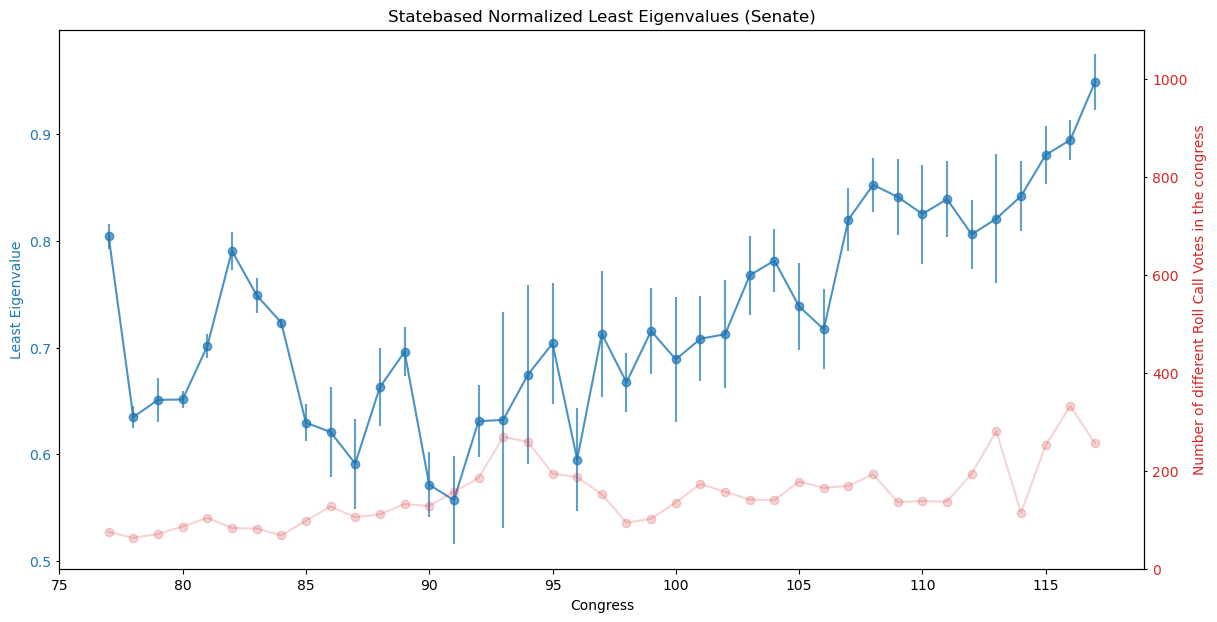

In [30]:
plot_statebased_frustrind('senate', n_votes_dic_senate, results_senate)

_________________________________________

### Visualize networks of interest

In [5]:
def draw_graph(df, pol_dic):
    G = nx.from_pandas_edgelist(df, 'source', 'target', ['weight'])

    nodeData = {list(g.state_abbrev)[0]: {'state': list(g.state_abbrev)[0], 'party': list(g.party_name)[0], 'color': list(g.color)[0], 'name': list(g.state_abbrev)[0]} for k, g in pol.groupby('state_abbrev')}
    nx.set_node_attributes(G, nodeData)

    colors = [node[1]['color'] for node in G.nodes(data=True)]
    
    fig, ax, pos, least_eigenvalue = draw_signed_networkx(G, node_color=colors, compact = True, theme="white", normalize=True, scale='log', jittering=0.01, margin=0.2, show_rotation=False, highlight_edges='frustrated', remove_n_outliers=3,sort_by='party');
    
    # print infos about users per party
    positions_party = {'pos': {'Democrat': 0,'Republican':0}, 'neg': {'Democrat': 0,'Republican':0}}
    for p in pos.keys():
        if pos[p].x > 0:
            if pol_dic[p]['party_name'] == 'Democrat' or pol_dic[p]['party_name'] == 'Republican':
                positions_party['pos'][pol_dic[p]['party_name']] += 1
        else:
            if pol_dic[p]['party_name'] == 'party_name' or pol_dic[p]['party_name'] == 'Republican':
                positions_party['neg'][pol_dic[p]['party_name']] += 1

    plt.text(0, .04, "Rep: "+str(positions_party['neg']['Republican']), fontsize=13, transform=ax.transAxes, color="ghostwhite")
    plt.text(0, .09, "Dem: "+str(positions_party['neg']['Democrat']), fontsize=13, transform=ax.transAxes, color="ghostwhite")

    plt.text(0.9, .04, "Rep: "+str(positions_party['pos']['Republican']), fontsize=13, transform=ax.transAxes, color="ghostwhite")
    plt.text(0.9, .09, "Dem: "+str(positions_party['pos']['Democrat']), fontsize=13, transform=ax.transAxes, color="ghostwhite")
    

    plt.show()

In [6]:
def draw_states_graph(df, pol_dic):
    G = nx.from_pandas_edgelist(df, 'source', 'target', ['weight'])

    nodeData = {list(g.state_abbrev)[0]: {'state': list(g.state_abbrev)[0], 'party': list(g.party_name)[0], 'color': list(g.color)[0], 'name': list(g.state_abbrev)[0]} for k, g in pol.groupby('state_abbrev')}
    nx.set_node_attributes(G, nodeData)

    colors = [node[1]['color'] for node in G.nodes(data=True)]
    
    fig, ax, pos, least_eigenvalue = draw_signed_states_networkx(G, node_color=colors, compact = True, theme="white", normalize=True, scale='log', jittering=0.01, margin=0.2, show_rotation=False, highlight_edges='frustrated', remove_n_outliers=3,sort_by='party');
    
    # print infos about users per party
    positions_party = {'pos': {'Democrat': 0,'Republican':0}, 'neg': {'Democrat': 0,'Republican':0}}
    for p in pos.keys():
        if pos[p].x > 0:
            if pol_dic[p]['party_name'] == 'Democrat' or pol_dic[p]['party_name'] == 'Republican':
                positions_party['pos'][pol_dic[p]['party_name']] += 1
        else:
            if pol_dic[p]['party_name'] == 'party_name' or pol_dic[p]['party_name'] == 'Republican':
                positions_party['neg'][pol_dic[p]['party_name']] += 1

    plt.text(0, .04, "Rep: "+str(positions_party['neg']['Republican']), fontsize=13, transform=ax.transAxes, color="ghostwhite")
    plt.text(0, .09, "Dem: "+str(positions_party['neg']['Democrat']), fontsize=13, transform=ax.transAxes, color="ghostwhite")

    plt.text(0.9, .04, "Rep: "+str(positions_party['pos']['Republican']), fontsize=13, transform=ax.transAxes, color="ghostwhite")
    plt.text(0.9, .09, "Dem: "+str(positions_party['pos']['Democrat']), fontsize=13, transform=ax.transAxes, color="ghostwhite")
    

    plt.show()

In [7]:
def read_edgelist(folder, threshold_pos, threshold_neg, congress_num):
    # read edgelist
    df = pd.read_csv(folder)
    df_pos = df.loc[(df['weight']==1)&(df['perc']>threshold_pos)].copy()
    df_neg = df.loc[(df['weight']==-1)&(df['perc']>threshold_neg)].copy()
    df = pd.concat([df_pos, df_neg])

    draw_graph(df, pol_dic)

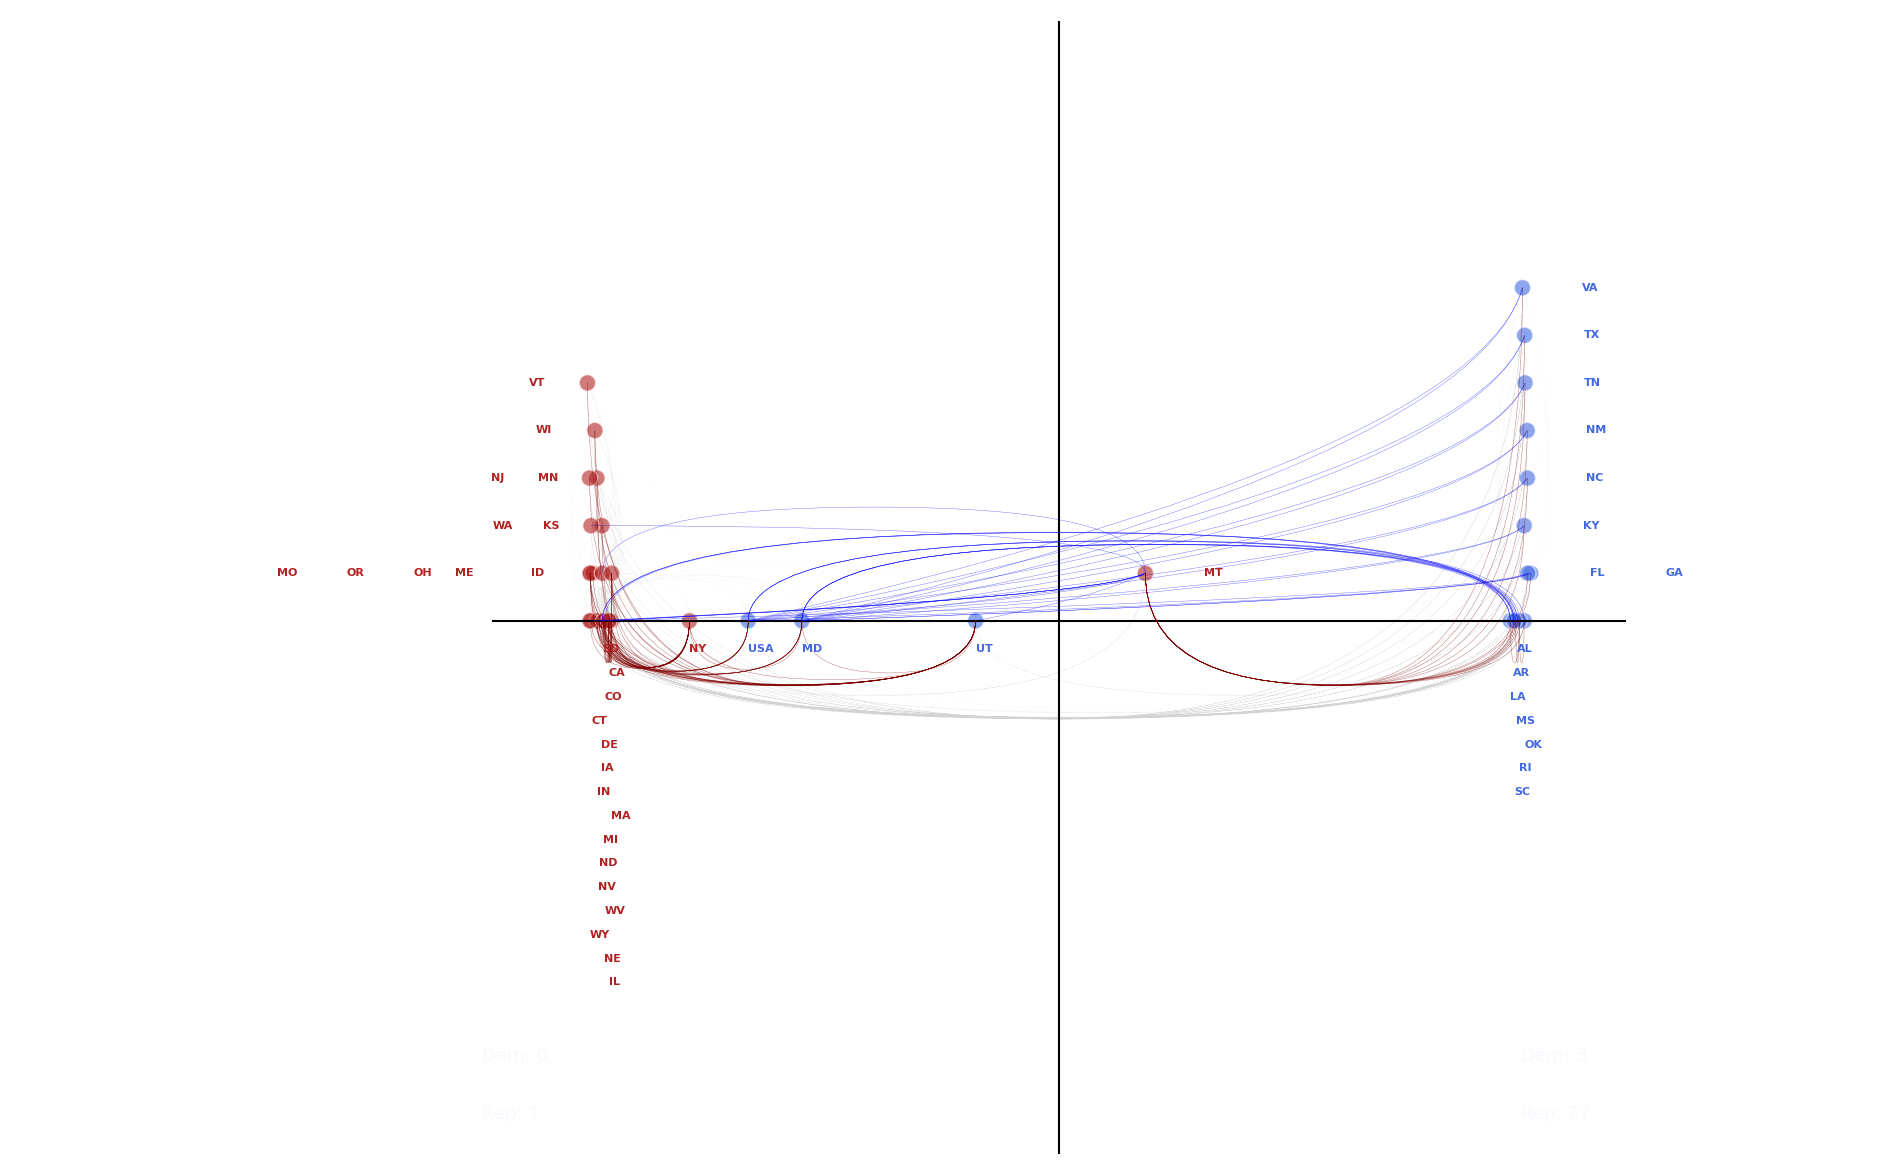

In [23]:
chamber = 'house'
cong = '080'
sim = '60'

pol_dic = pd.read_csv('../dataset/statebased_analysis/mc_statebased_poldics_'+chamber+'/congress_'+cong+'/poldic_'+cong+'_'+sim+'.csv', header=None, index_col=0).to_dict()
pol = pd.DataFrame.from_dict(pol_dic[1], orient='index').reset_index()
pol.columns = ['state_abbrev', 'party_name']
pol['color'] = pol['party_name'].apply(lambda x: 'firebrick' if 'Republican' in x else ('royalblue' if 'Democrat' in x else 'green'))
pol_dic = pol[['state_abbrev', 'party_name']].set_index('state_abbrev').to_dict(orient="index")
threshold_neg = pd.read_csv('../dataset/statebased_analysis/mc_statebased_thresholds_'+chamber+'/congress_'+cong+'/threshold_'+cong+'_'+sim+'.csv')['neg_threshold'][0]
threshold_pos = pd.read_csv('../dataset/statebased_analysis/mc_statebased_thresholds_'+chamber+'/congress_'+cong+'/threshold_'+cong+'_'+sim+'.csv')['pos_threshold'][0]
folder = '../dataset/statebased_analysis/mc_statebased_edgelists_'+chamber+'/congress_'+cong+'/edgelist_'+cong+'_'+sim+'.csv'
congress_num = str(cong)

read_edgelist(folder, threshold_pos, threshold_neg, congress_num)